In [193]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from imageio.v2 import imread

def readFlow(fn):
    """ Read .flo file in Middlebury format"""
    # Code adapted from:
    # http://stackoverflow.com/questions/28013200/reading-middlebury-flow-files-with-python-bytes-array-numpy

    # WARNING: this will work on little-endian architectures (eg Intel x86) only!
    # print 'fn = %s'%(fn)
    with open(fn, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        if 202021.25 != magic:
            print('Magic number incorrect. Invalid .flo file')
            return None
        else:
            w = np.fromfile(f, np.int32, count=1)
            h = np.fromfile(f, np.int32, count=1)
            # print 'Reading %d x %d flo file\n' % (w, h)
            data = np.fromfile(f, np.float32, count=2 * int(w) * int(h))
            # Reshape testdata into 3D array (columns, rows, bands)
            # The reshape here is for visualization, the original code is (w,h,2)
            return np.resize(data, (int(h), int(w), 2))
def path_to_img_arr(path,to_crop = True):
  im = imread(path)
  h , w , _ = im.shape  
  new_h = h//64 *64
  new_w = w//64 * 64
  if to_crop:  
      im = im[(h-new_h)//2:(h+new_h)//2,(w-new_w)//2:(w+new_w)//2,:]
  return im

def warp(im, flow, alpha=1, interp=cv2.INTER_CUBIC):
    height, width, _ = flow.shape
    cart = np.dstack(np.meshgrid(np.arange(width), np.arange(height)))
    pixel_map = (cart + alpha * flow).astype(np.float32)
    warped = cv2.remap(
        im,
        pixel_map[:, :, 0],
        pixel_map[:, :, 1],
        interp)
    return warped

def warp2(curImg ,flow):
  h, w = flow.shape[:2]
  flow = -flow
  flow[:,:,0] += np.arange(w)
  flow[:,:,1] += np.arange(h)[:,np.newaxis]
  prevImg = cv2.remap(curImg, flow, None, cv2.INTER_LINEAR)
  return prevImg
def warp3(img,flo):
  batched_img = np.reshape(img, (1, *img.shape))
  torch_img = torch.from_numpy(batched_img)
  torch_img = torch.from_numpy(np.transpose(batched_img, (0, 3, 1, 2)))
  batched_flo = np.reshape(flo, (1, *flo.shape))
  torch_flo = torch.from_numpy(batched_flo)
  torch_flo = torch.from_numpy(np.transpose(batched_flo, (0, 3, 1, 2)))
  return warp_pwc(torch_img,torch_flo)

def warp_pwc(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow

    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow

    """
    B, C, H, W = x.size()
    # mesh grid
    xx = torch.arange(0, W).view(1,-1).repeat(H,1)
    yy = torch.arange(0, H).view(-1,1).repeat(1,W)
    xx = xx.view(1,1,H,W).repeat(B,1,1,1)
    yy = yy.view(1,1,H,W).repeat(B,1,1,1)
    grid = torch.cat((xx,yy),1).float()

    if x.is_cuda:
        grid = grid.cuda()
    vgrid = Variable(grid) + flo

    # scale grid to [-1,1]
    vgrid[:,0,:,:] = 2.0*vgrid[:,0,:,:].clone() / max(W-1,1)-1.0
    vgrid[:,1,:,:] = 2.0*vgrid[:,1,:,:].clone() / max(H-1,1)-1.0

    vgrid = vgrid.permute(0,2,3,1)
    output = nn.functional.grid_sample(x, vgrid)
    mask = torch.autograd.Variable(torch.ones(x.size())).cuda()
    mask = nn.functional.grid_sample(mask, vgrid)

    mask[mask<0.999] = 0
    mask[mask>0] = 1

    return output*mask

def diff_show(path1 , path2):

    plt.figure(figsize=(5,5))
    image_ref = path_to_img_arr(path1)
    plt.imshow(image_ref)
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(5,5))
    image_mod =path_to_img_arr(path2)
    plt.imshow(image_mod)
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(image_mod, cv2.COLOR_BGR2GRAY) - cv2.cvtColor(image_ref, cv2.COLOR_BGR2GRAY))
    plt.axis('off')
    plt.show()

    plt.close()

In [194]:
sources = "../../sources/"
images_dir = sources+"/images"
flow_res = sources+"/flows"
mod = images_dir + "/demo_mod"
ref = images_dir + "/demo_ref"
Xm1 = mod + "/openimage_0995.png"
Xo1 = ref + "/openimage_0995.png"
res_example = images_dir + "/res_example"
flownet = flow_res + "/FlowNet2.flo"
spynet = flow_res + "/openimage_0995.flo"
openimage_0995_res = res_example + "/openimage_0995_ref_like.png"

In [195]:
#!python SpyNet/pred.py --model sintel-final --one $mod --two $ref --out $flow_res

In [196]:
!ls $res_example

openimage_0995_ref_like.png


In [307]:
from PIL import Image
import torch

flow = spynet
is_flownet = False 
factor = 0.001
Xm1_PIL = Image.open(Xm1).convert('RGB')
Xo1_PIL = Image.open(Xo1).convert('RGB')
if is_flownet:
    Xm1_PIL = Xm1_PIL.resize([384,384])
    Xo1_PIL = Xo1_PIL.resize([384,384])
    flow = flownet
Xm1_numpy = np.array(Xm1_PIL)
flow_numpy = readFlow(flow)

pim1 = path_to_img_arr(Xm1,is_flownet)
pim2 = path_to_img_arr(Xo1,is_flownet)
images = [pim1, pim1]
images = np.array(images).transpose(3, 0, 1, 2)
inputs = torch.from_numpy(images.astype(np.float32)).unsqueeze(0).cuda()
rgb_mean = inputs.contiguous().view(inputs.size()[:2]+(-1,)).mean(dim=-1).view(inputs.size()[:2] + (1,1,1,))
x = (inputs -rgb_mean*factor) / 255
x1 = x[:,:,0,:,:]
x2 = x[:,:,1,:,:]
x = torch.cat((x1,x2), dim = 1)


/tmp/ipykernel_1177/268263338.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = np.fromfile(f, np.float32, count=2 * int(w) * int(h))
/tmp/ipykernel_1177/268263338.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.resize(data, (int(h), int(w), 2))


In [315]:
#use resample2d FlowNet2.0
import torch
from FlowNet2.networks.resample2d_package.resample2d import Resample2d
from torchvision.transforms.functional import pil_to_tensor

resample = Resample2d()
def toTensor(x_numpy,type =torch.float):
    res = torch.tensor(x_numpy,dtype = type)
    return res.permute(2,0,1).unsqueeze(0).cuda()

Xm1_torch = x[:,:3,:,:]
Xo1_torch = x[:,3:,:,:]
flow_torch = toTensor(flow_numpy).contiguous()


In [326]:
warp2_kit = (Xm1_numpy , flow_numpy ,warp2)
resample2d_kit = (Xm1_torch , flow_torch*-1.05 , resample) 

In [327]:
def warping(kit):
    im , flow ,warp = kit
    return warp(im,flow)

im_a = warping(resample2d_kit)
im_b = warping(warp2_kit)
im_b =torch.tensor(im_b).permute(2,0,1).unsqueeze(0).cuda()


Resample2d :  img.size = torch.Size([1, 3, 417, 430]), flow_size (flow?) = torch.Size([1, 2, 417, 430])
Resample2d :  output shape = torch.Size([1, 3, 417, 430])
Resample2d :  output  = tensor([[[[0.1953, 0.1802, 0.1957,  ..., 0.9761, 0.9991, 0.8680],
          [0.2213, 0.1995, 0.2177,  ..., 0.9954, 0.9984, 0.9569],
          [0.2041, 0.1935, 0.2258,  ..., 0.9834, 0.9757, 0.9950],
          ...,
          [0.7750, 0.7887, 0.8016,  ..., 0.1643, 0.1379, 0.1378],
          [0.7759, 0.7843, 0.7823,  ..., 0.1908, 0.1492, 0.1404],
          [0.7759, 0.7735, 0.7731,  ..., 0.1492, 0.1521, 0.1620]],

         [[0.1291, 0.1256, 0.1450,  ..., 0.9841, 0.9994, 0.8388],
          [0.1551, 0.1450, 0.1669,  ..., 0.9997, 0.9988, 0.9278],
          [0.1380, 0.1390, 0.1751,  ..., 0.9992, 0.9801, 0.9739],
          ...,
          [0.3164, 0.3297, 0.3393,  ..., 0.1136, 0.0869, 0.0866],
          [0.3174, 0.3257, 0.3200,  ..., 0.1401, 0.0985, 0.0896],
          [0.3174, 0.3082, 0.3072,  ..., 0.0986, 0.1014,

In [328]:
im = im_a
im.shape
im

tensor([[[[0.1953, 0.1802, 0.1957,  ..., 0.9761, 0.9991, 0.8680],
          [0.2213, 0.1995, 0.2177,  ..., 0.9954, 0.9984, 0.9569],
          [0.2041, 0.1935, 0.2258,  ..., 0.9834, 0.9757, 0.9950],
          ...,
          [0.7750, 0.7887, 0.8016,  ..., 0.1643, 0.1379, 0.1378],
          [0.7759, 0.7843, 0.7823,  ..., 0.1908, 0.1492, 0.1404],
          [0.7759, 0.7735, 0.7731,  ..., 0.1492, 0.1521, 0.1620]],

         [[0.1291, 0.1256, 0.1450,  ..., 0.9841, 0.9994, 0.8388],
          [0.1551, 0.1450, 0.1669,  ..., 0.9997, 0.9988, 0.9278],
          [0.1380, 0.1390, 0.1751,  ..., 0.9992, 0.9801, 0.9739],
          ...,
          [0.3164, 0.3297, 0.3393,  ..., 0.1136, 0.0869, 0.0866],
          [0.3174, 0.3257, 0.3200,  ..., 0.1401, 0.0985, 0.0896],
          [0.3174, 0.3082, 0.3072,  ..., 0.0986, 0.1014, 0.1113]],

         [[0.0977, 0.0905, 0.1138,  ..., 0.9293, 0.9485, 0.7879],
          [0.1238, 0.1100, 0.1359,  ..., 0.9525, 0.9515, 0.8770],
          [0.1066, 0.1040, 0.1442,  ..., 0

In [329]:
from torchvision.transforms import ToPILImage
print(im.dtype)
makePIL =ToPILImage()
im = im.squeeze()
ModtoOrig = makePIL(im)
ModtoOrig.save(openimage_0995_res)

torch.float32


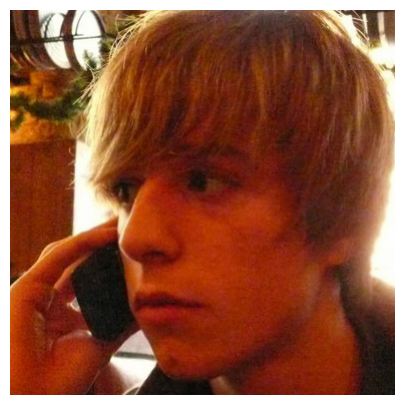

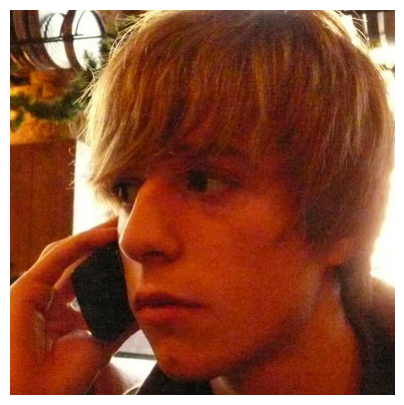

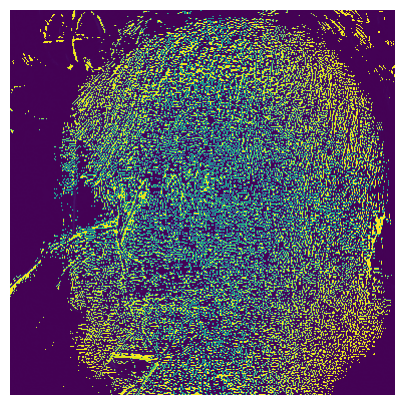

In [330]:
diff_show(openimage_0995_res,Xo1)
